In [1]:
# back to project root
%cd ~/research

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm
import sys
from glob import glob
import yaml

sys.path.append('src')
# from group.passing.dataset import make_all_data
from utility.logger import logger
from utility.activity_loader import load_individuals

/raid6/home/yokoyama/research


/home/yokoyama/research/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Indivisual Activity をロード

In [5]:
cfg_path = "config/passing/pass_train.yaml"
with open(cfg_path, "r") as f:
    train_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["individual"], "r") as f:
    ind_cfg = yaml.safe_load(f)
with open(train_cfg["config_path"]["group"], "r") as f:
    grp_cfg = yaml.safe_load(f)

In [6]:
data_dirs_all = {}
for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
    for surgery_num in surgery_items.keys():
        dirs = sorted(glob(os.path.join("data", room_num, surgery_num, "passing", "*")))
        data_dirs_all[f"{room_num}_{surgery_num}"] = dirs

inds = {}
for key_prefix, dirs in tqdm(data_dirs_all.items()):
    for model_path in dirs:
        num = model_path.split("/")[-1]
        json_path = os.path.join(model_path, ".json", "individual.json")
        tmp_inds = load_individuals(json_path, ind_cfg)
        for pid, ind in tmp_inds.items():
            inds[f"{key_prefix}_{num}_{pid}"] = ind

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:15<00:00, 12.60s/it]


# 特徴量抽出とデータ生成

In [7]:
import os
from logging import Logger
from types import SimpleNamespace
from typing import Any, Dict

import numpy as np
import torch
from individual.individual import Individual
from tqdm import tqdm
from utility import json_handler
from utility.functions import cos_similarity, gauss

def make_all_data(
    individuals: Dict[str, Individual],
    dataset_cfg: dict,
    passing_defs: dict,
    logger: Logger,
):
    x_dict: Dict[str, Any] = {}
    y_dict: Dict[str, Any] = {}
    data_all = _make_time_series_from_cfg(dataset_cfg, logger)
    for room_num, room_data in data_all.items():
        for surgery_num, surgery_data in room_data.items():
            logger.info(f"=> extracting feature {room_num}_{surgery_num}")
            for data_num, time_series in tqdm(surgery_data.items()):
                queue_dict: Dict[str, list] = {}
                for pair_key, row in time_series.items():
                    id1, id2 = pair_key.split("_")
                    for (frame_num, is_pass) in row:
                        # frame_num, is_pass = row[0], row[1]

                        ind1 = individuals[f"{room_num}_{surgery_num}_{data_num}_{id1}"]
                        ind2 = individuals[f"{room_num}_{surgery_num}_{data_num}_{id2}"]

                        # queue
                        pair_key = f"{ind1.id}_{ind2.id}"
                        if pair_key not in queue_dict:
                            queue_dict[pair_key] = []
                        feature_que = queue_dict[pair_key]

                        # extract feature
                        feature_que = extract_feature(
                            ind1,
                            ind2,
                            feature_que,
                            frame_num,
                            passing_defs,
                            with_padding=False,
                        )

                        # save data
                        key = f"{room_num}_{surgery_num}_{data_num}_{ind1.id}_{ind2.id}"
                        if key not in x_dict:
                            x_dict[key] = []
                            y_dict[key] = []

                        if len(feature_que) > 0:
                            x_dict[key].append(feature_que[-1])
                            y_dict[key].append(is_pass)

    return x_dict, y_dict


def _make_time_series_from_cfg(dataset_cfg: dict, logger: Logger):
    ret_data = {}
    for room_num, room_cfg in dataset_cfg.items():
        room_data = {}
        for surgery_num, surgery_cfg in room_cfg.items():
            logger.info(f"=> createing time series {room_num}_{surgery_num}")
            surgery_data = {}
            for data_num, row in tqdm(surgery_cfg.items()):
                settings = []
                for item in row:
                    settings.append(
                        {
                            "id1": item[0],
                            "id2": item[1],
                            "begin": int(item[2]),
                            "end": int(item[3]),
                        }
                    )

                kps_json_path = os.path.join(
                    "data",
                    room_num,
                    surgery_num,
                    "passing",
                    data_num,
                    ".json",
                    "keypoints.json",
                )
                kps_data = json_handler.load(kps_json_path)

                max_frame = kps_data[-1]["frame"]
                time_series: Dict[str, list] = {}
                for frame_num in range(max_frame):
                    frame_data = [
                        data for data in kps_data if data["frame"] == frame_num
                    ]

                    for i in range(len(frame_data) - 1):
                        for j in range(i + 1, len(frame_data)):
                            id1 = frame_data[i]["id"]
                            id2 = frame_data[j]["id"]

                            pair_key = f"{id1}_{id2}"
                            if pair_key not in time_series:
                                time_series[pair_key] = []

                            is_pass = 0
                            for item in settings:
                                if (id1 == item["id1"] and id2 == item["id2"]) or (
                                    id1 == item["id2"] and id2 == item["id1"]
                                ):
                                    if (
                                        item["begin"] <= frame_num
                                        and frame_num <= item["end"]
                                    ):
                                        is_pass = 1

                            time_series[pair_key].append((frame_num, is_pass))

                surgery_data[data_num] = time_series
            room_data[surgery_num] = surgery_data
        ret_data[room_num] = room_data
    return ret_data


def _get_indicators(ind: Individual, frame_num: int):
    pos = ind.get_indicator("position", frame_num)
    body = ind.get_indicator("body", frame_num)
    arm = ind.get_indicator("arm", frame_num)
    wrist = (
        ind.get_keypoints("LWrist", frame_num),
        ind.get_keypoints("RWrist", frame_num),
    )
    ret = {"pos": pos, "body": body, "arm": arm, "wrist": wrist}
    return ret


def extract_feature(
    ind1: Individual,
    ind2: Individual,
    que: list,
    frame_num: int,
    defs: dict,
    with_padding: bool = True,
):
    # get indicator
    ind1_data = _get_indicators(ind1, frame_num)
    ind2_data = _get_indicators(ind2, frame_num)

    if not (None in ind1_data.values() or None in ind2_data.values()):
        ind1_data = SimpleNamespace(**ind1_data)
        ind2_data = SimpleNamespace(**ind2_data)

        # calc distance of position
        p1_pos = np.array(ind1_data.pos)
        p2_pos = np.array(ind2_data.pos)

        norm = np.linalg.norm(p1_pos - p2_pos, ord=2)
        distance = gauss(norm, mu=defs["dist_mu"], sigma=defs["dist_sig"])
        # distance = norm

        p1p2 = p2_pos - p1_pos
        p2p1 = p1_pos - p2_pos

        p1p2_sim = cos_similarity(ind1_data.body, p1p2)
        p2p1_sim = cos_similarity(ind2_data.body, p2p1)
        body_direction = (np.average([p1p2_sim, p2p1_sim]) + 1) / 2

        # calc arm average
        arm_ave = np.average([ind1_data.arm, ind2_data.arm])

        # calc wrist distance
        min_norm = np.inf
        for i in range(2):
            for j in range(2):
                norm = np.linalg.norm(
                    np.array(ind1_data.wrist[i]) - np.array(ind2_data.wrist[j]), ord=2
                )
                min_norm = float(norm) if norm < min_norm else min_norm

        wrist_distance = gauss(min_norm, mu=defs["wrist_mu"], sigma=defs["wrist_sig"])
        # wrist_distance = min_norm

        # concatnate to feature
        feature = [distance, body_direction, arm_ave, wrist_distance]
        que.append(feature)

    if len(que) < defs["seq_len"]:
        # 0 padding
        if with_padding:
            return que + [[0, 0, 0, 0] for _ in range(defs["seq_len"] - len(que))]
        else:
            return que
    else:
        return que[-defs["seq_len"] :]

In [8]:
# create model
x_dict, y_dict = make_all_data(inds, train_cfg["dataset"]["setting"], grp_cfg["passing"]["default"], logger)

2022-07-14 17:37:06,743 => createing time series 02_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.23it/s]
2022-07-14 17:37:12,006 => createing time series 07_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]
2022-07-14 17:37:47,876 => createing time series 08_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:07<00:00,  4.81it/s]
2022-07-14 17:37:55,773 => createing time series 08_002
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:38<00:00,  1.17it/s]
2022-07-14 17:38:34,369 => createing time series 09_001
100%|███████████████████████████████

In [9]:
for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
    print(room_num)
    
    y_lst_all = []
    for key, y_lst in y_dict.items():
        if key[:2] == room_num:
            y_lst_all += y_lst

    len_pass = len([i for i in y_lst_all if i == 1])
    len_not_pass = len([i for i in y_lst_all if i == 0])

    print(f'all length:{len(y_lst_all)}')
    print(f'passing: {len_pass}')
    print(f'not passing: {len_not_pass}')
    
print('total')
y_lst_all = []
for key, y_lst in y_dict.items():
    y_lst_all += y_lst

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

02
all length:123982
passing: 582
not passing: 123400
07
all length:526797
passing: 2264
not passing: 524533
08
all length:704330
passing: 3179
not passing: 701151
09
all length:456480
passing: 1091
not passing: 455389
total
all length:1811589
passing: 7116
not passing: 1804473


In [10]:
# setting random seed
np.random.seed(train_cfg["dataset"]["random_seed"])
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

train_ratio = train_cfg["dataset"]["train_ratio"] + train_cfg["dataset"]["val_ratio"]
train_len = int(len(x_dict) * train_ratio)

train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}

In [11]:
train_1 = {key: y_dict[key] for key in train_keys if 1 in y_dict[key]}
print(len(train_1))
train_0 = {key: y_dict[key] for key in train_keys if 0 in y_dict[key]}
print(len(train_0))

train_1_frame = 0
train_0_frame = 0
for data in y_train_dict.values():
    train_1_frame += len([val for val in data if val == 1])
    train_0_frame += len([val for val in data if val == 0])
    
print(train_1_frame)
print(train_0_frame)

119
12932
5162
1446729


In [12]:
test_1 = {key: y_dict[key] for key in test_keys if 1 in y_dict[key]}
print(len(test_1))
test_0 = {key: y_dict[key] for key in test_keys if 0 in y_dict[key]}
print(len(test_0))

test_1_frame = 0
test_0_frame = 0
for data in y_test_dict.values():
    test_1_frame += len([val for val in data if val == 1])
    test_0_frame += len([val for val in data if val == 0])
print(test_1_frame)
print(test_0_frame)

43
3234
1954
357744


# 分布

In [13]:
def extract_feature(x_dict, y_dict, col_num, is_pass):
    hist = {}
    for room_num, surgery_items in train_cfg["dataset"]["setting"].items():
        for _ in surgery_items.keys():
            hist_room = []
            for key, x_lst, y_lst in zip(x_dict.keys(), x_dict.values(), y_dict.values()):
                x_lst = np.array(x_lst)
                if room_num in key and is_pass in y_lst:
                    hist_room += x_lst.T[col_num].tolist()
            hist[room_num] = hist_room
        
    return hist

## 受け渡し動作中の距離の分布を見る

In [14]:
hist_dist_1 = extract_feature(
    x_dict,
    y_dict,
    0,
    1
)

0.7739295563656771
0.2412362723787224


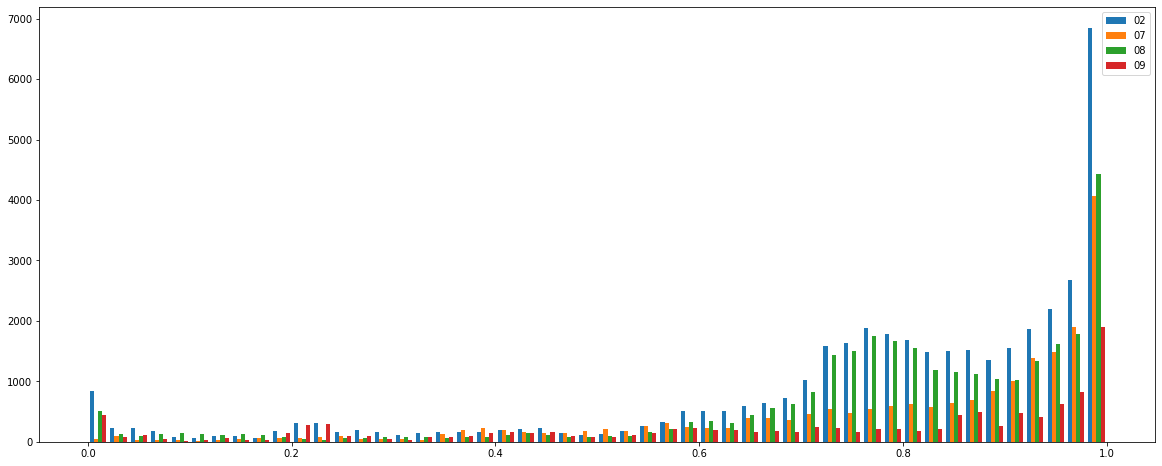

In [30]:
data = []
for vals in hist_dist_1.values():
    for val in vals:
        # if val < 2000:
        data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_dist_1.values(), bins=50, range=(0, 1), label=list(hist_dist_1.keys()))
# plt.vlines(np.mean(data), 0, 1000)
plt.legend()

In [16]:
hist_dist_0 = extract_feature(
    x_dict,
    y_dict,
    0,
    0
)

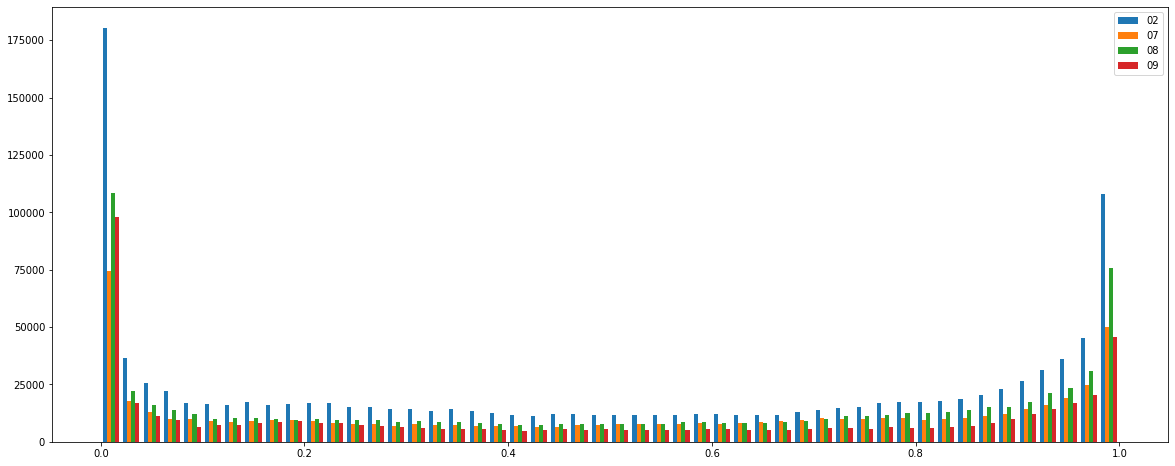

In [31]:
plt.figure(figsize=(20, 8))
plt.hist(hist_dist_0.values(), bins=50, range=(0, 1), label=list(hist_dist_0.keys()))
plt.legend()

## 受け渡し動作中の体の向きの分布を見る

In [18]:
hist_body_1 = extract_feature(
    x_dict,
    y_dict,
    1,
    1
)

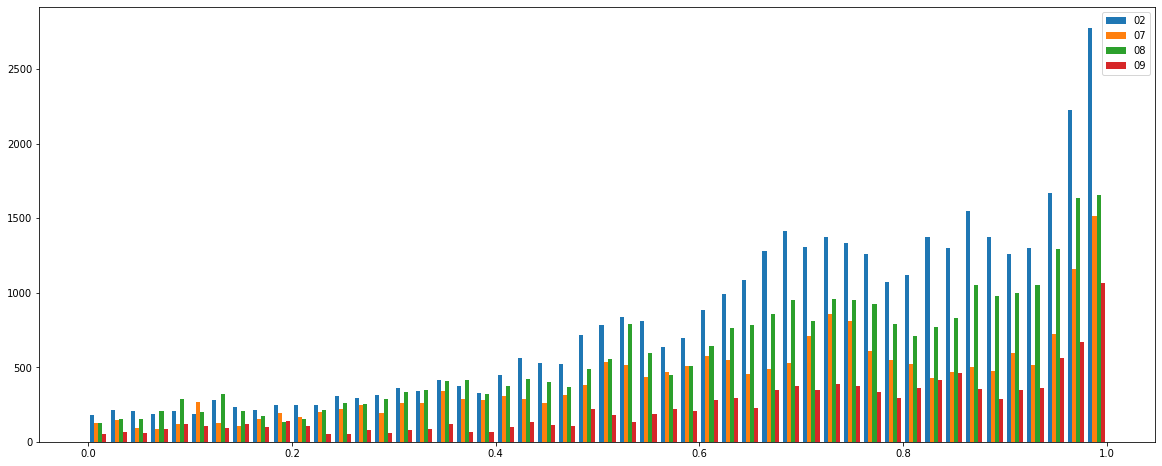

In [19]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_1.values(), bins=50, range=(0, 1), label=list(hist_body_1.keys()))
plt.legend()

In [20]:
hist_body_0 = extract_feature(
    x_dict,
    y_dict,
    1,
    0
)

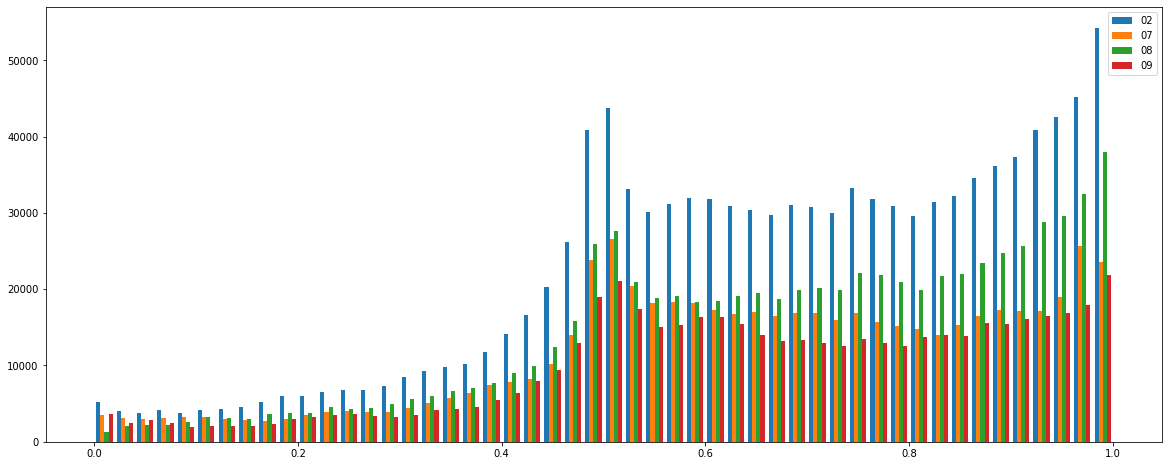

In [21]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_0.values(), bins=50, range=(0, 1), label=list(hist_body_0.keys()))
plt.legend()

## 受け渡し動作中の腕の上げ下げの分布を見る

In [22]:
hist_arm_1 = extract_feature(
    x_dict,
    y_dict,
    2,
    1
)

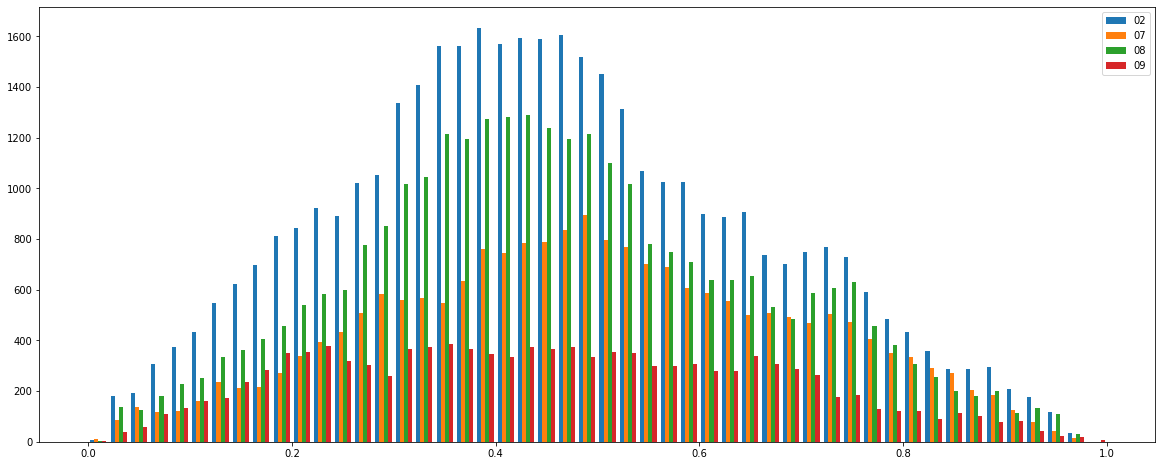

In [23]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_1.values(), bins=50, range=(0, 1), label=list(hist_arm_1.keys()))
plt.legend()

In [24]:
hist_arm_0 = extract_feature(
    x_dict,
    y_dict,
    2,
    0
)

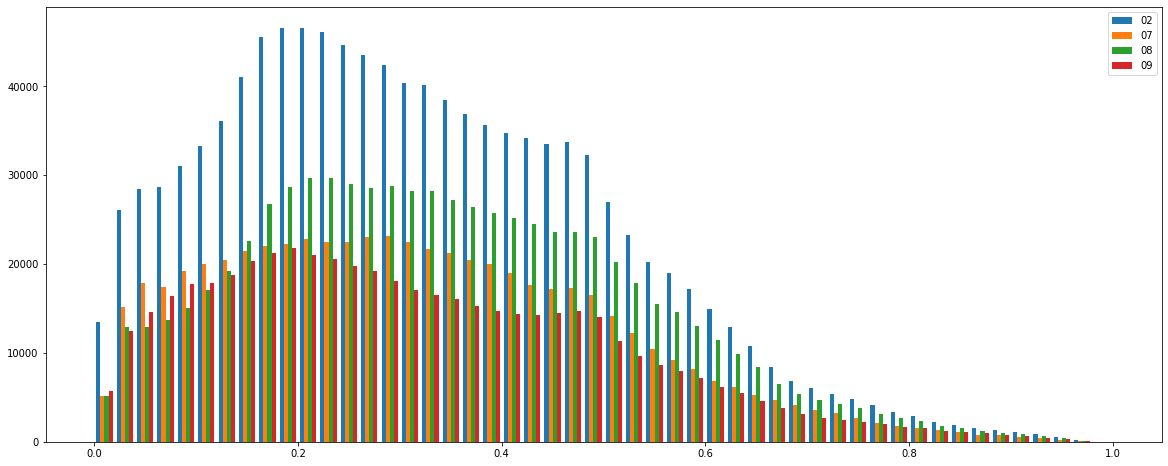

In [25]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_0.values(), bins=50, range=(0, 1), label=list(hist_arm_0.keys()))
plt.legend()

## 受け渡し動作中の手首の距離の分布を見る

In [26]:
hist_wrist_1 = extract_feature(
    x_dict,
    y_dict,
    3,
    1
)

0.6899137869116848
0.26645400198525315


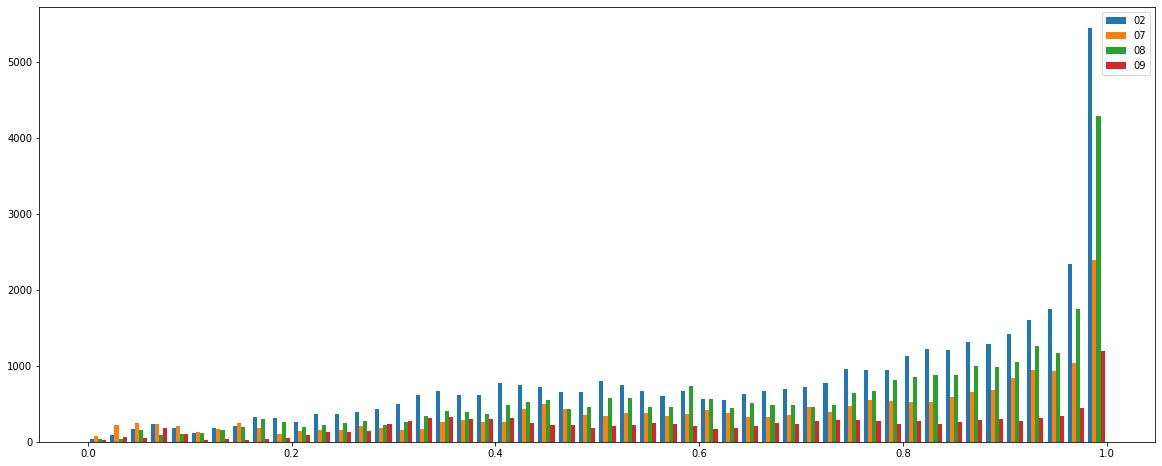

In [32]:
data = []
for vals in hist_wrist_1.values():
    for val in vals:
        # if val < 2000:
        data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_1.values(), bins=50, range=(0, 1), label=list(hist_wrist_1.keys()))
plt.legend()

In [28]:
hist_wrist_0 = extract_feature(
    x_dict,
    y_dict,
    3,
    0
)

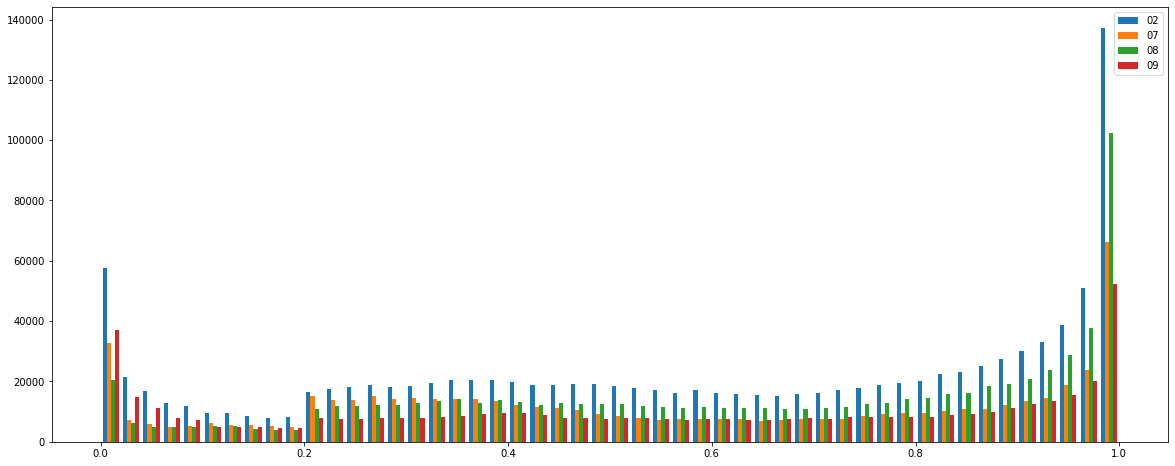

In [33]:
plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_0.values(), bins=50, range=(0, 1), label=list(hist_wrist_0.keys()))
plt.legend()

# 時系列でプロット

02_001_02_10_11


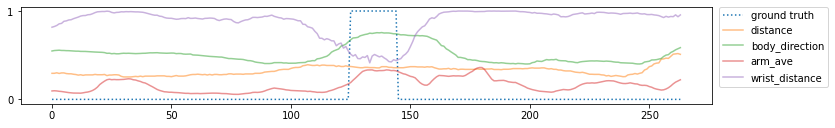

02_001_02_10_13


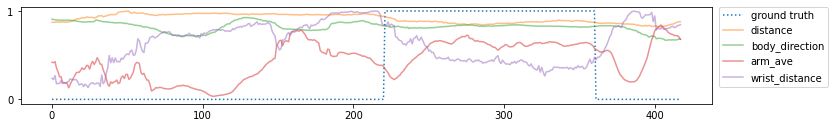

02_001_03_27_31


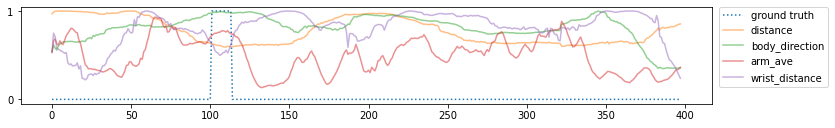

02_001_04_43_42


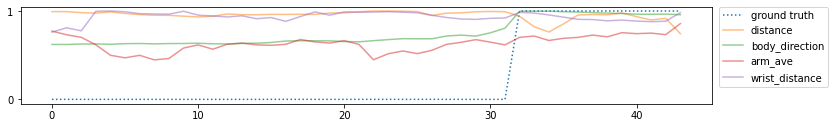

02_001_05_47_51


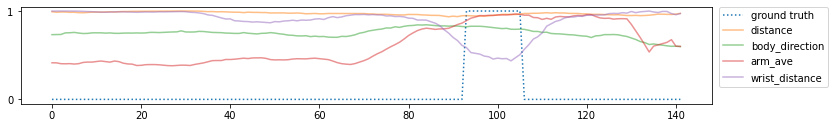

02_001_06_58_61


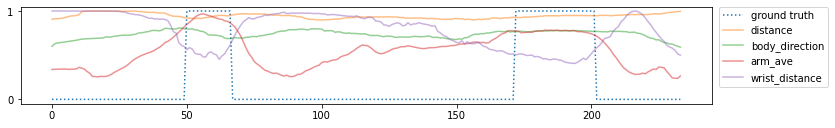

02_001_08_81_85


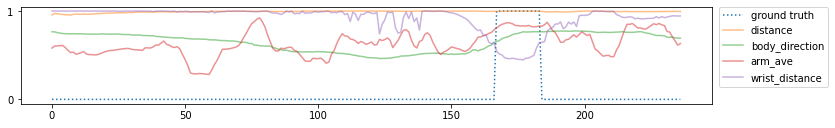

02_001_09_97_104


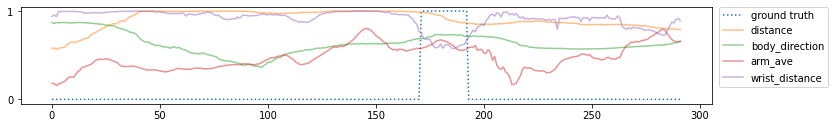

02_001_10_125_119


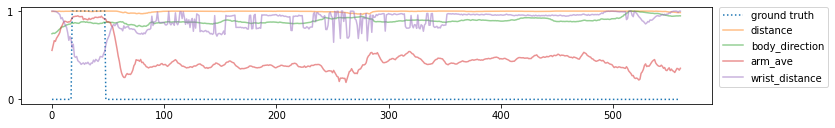

02_001_11_134_140


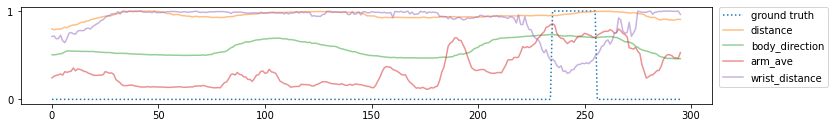

02_001_13_166_167


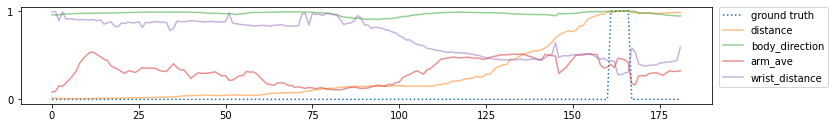

02_001_15_191_202


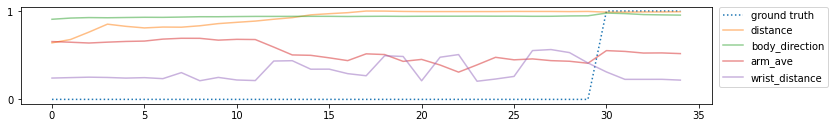

02_001_15_202_191


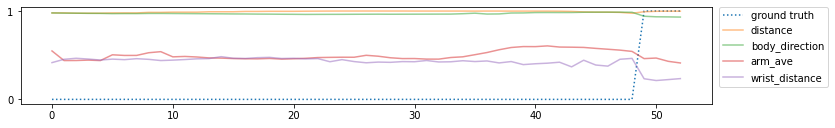

02_001_18_247_251


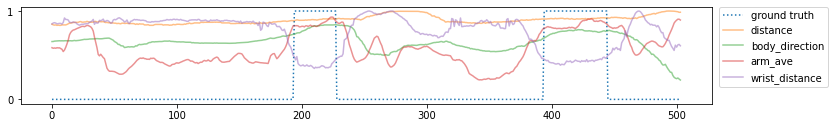

02_001_19_259_262


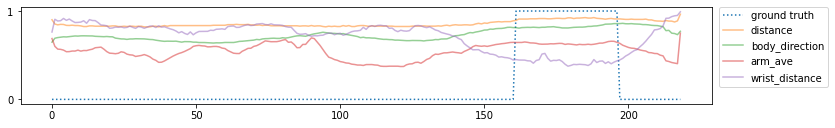

02_001_20_268_270


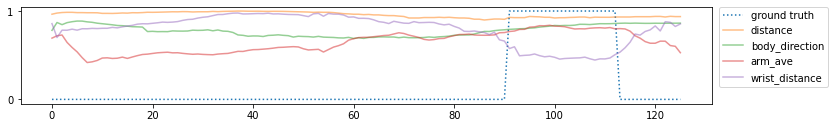

02_001_20_268_266


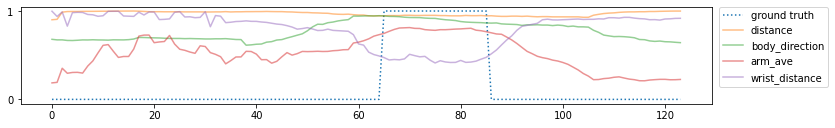

02_001_21_288_287


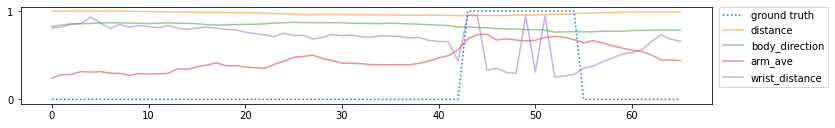

02_001_22_289_295


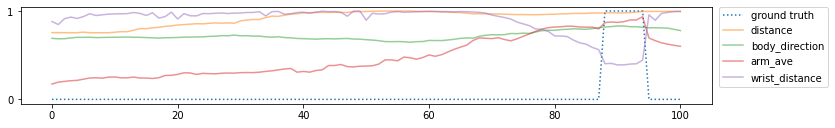

02_001_23_304_309


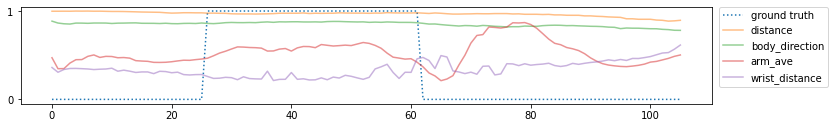

07_001_02_20_18


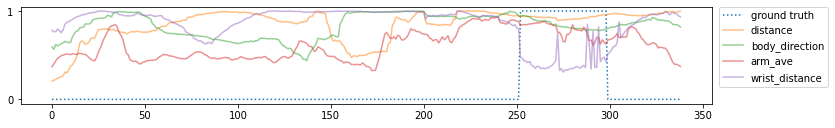

07_001_03_33_28


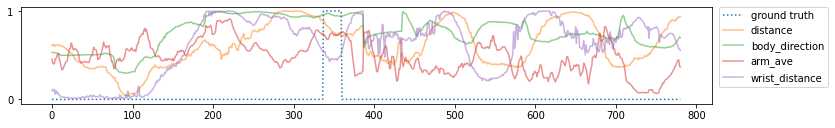

07_001_04_58_50


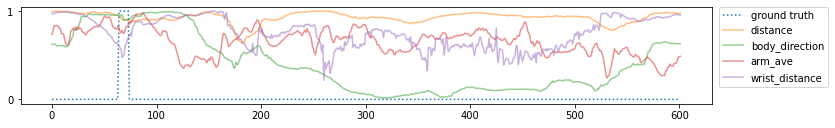

07_001_05_54_79


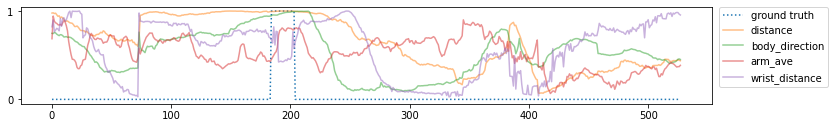

07_001_06_84_98


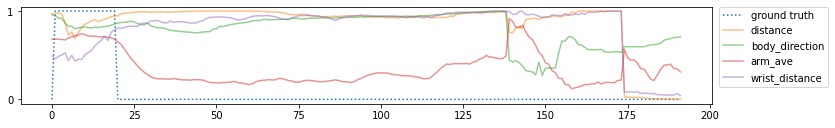

07_001_07_116_121


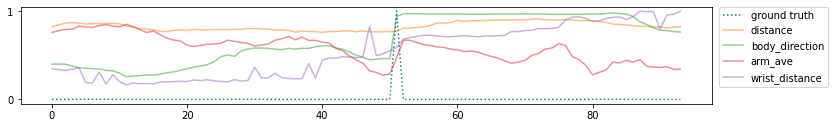

07_001_07_121_116


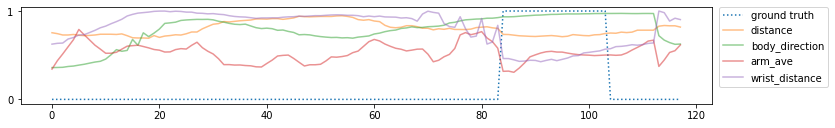

07_001_09_153_158


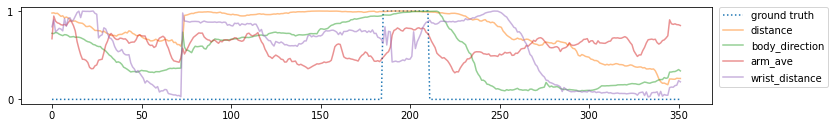

07_001_10_167_158


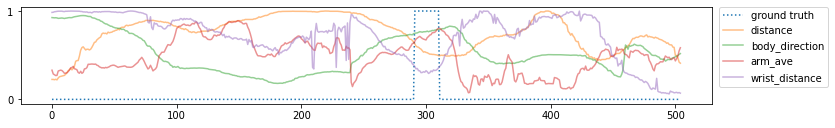

07_001_11_167_158


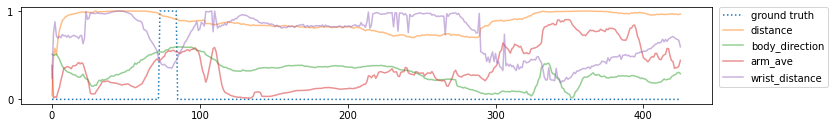

07_001_12_195_191


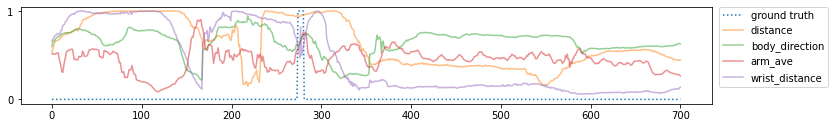

07_001_13_217_219


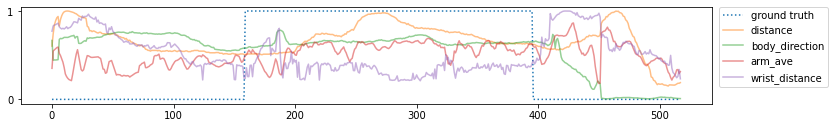

07_001_14_232_230


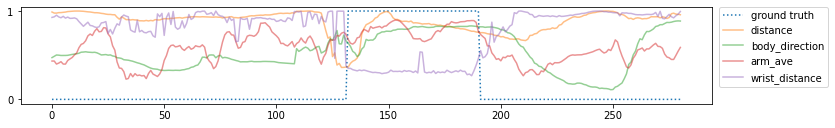

07_001_15_232_247


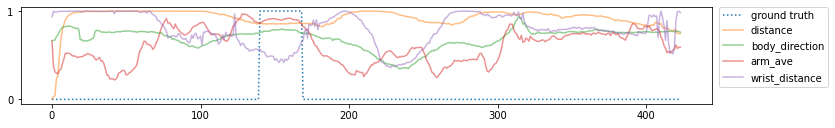

07_001_16_267_252


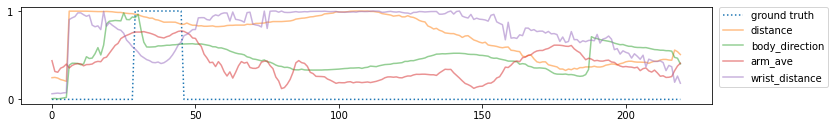

07_001_17_265_285


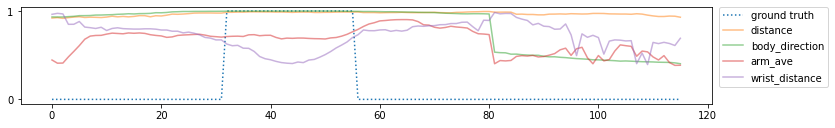

07_001_18_293_297


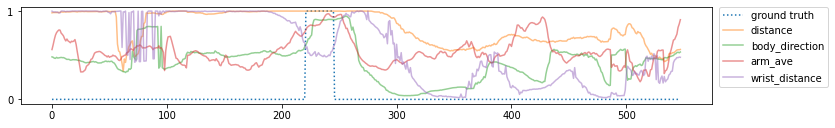

07_001_19_308_304


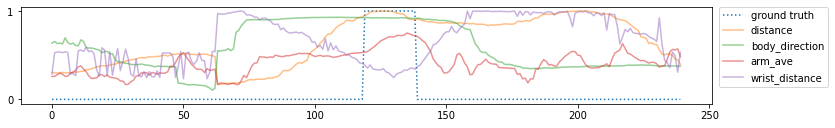

07_001_20_304_333


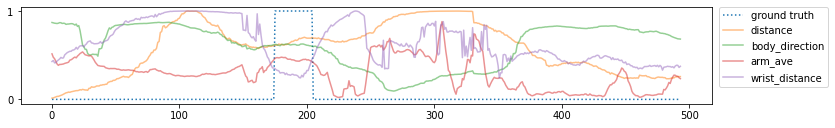

07_001_21_297_317


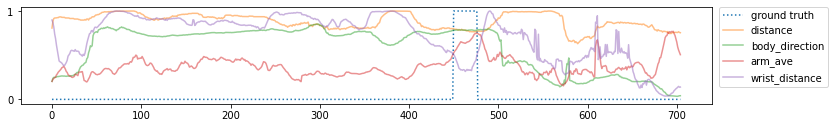

07_001_22_356_297


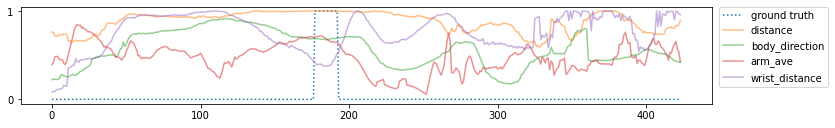

07_001_23_356_367


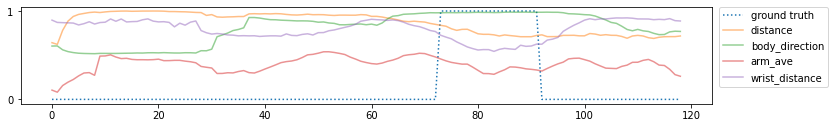

07_001_24_370_375


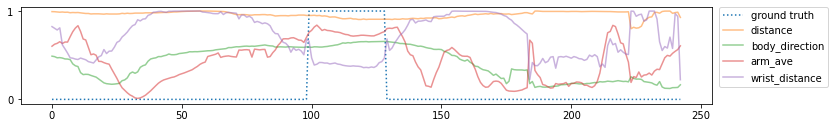

07_001_25_390_392


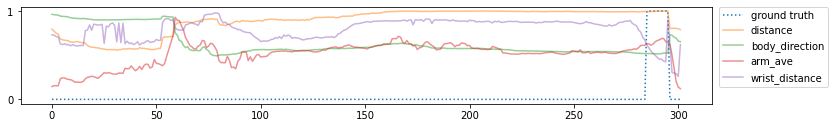

07_001_26_404_405


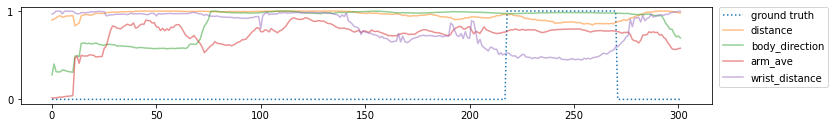

07_001_26_405_415


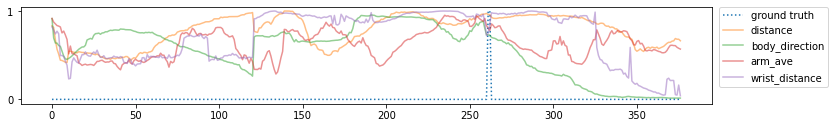

07_001_27_415_405


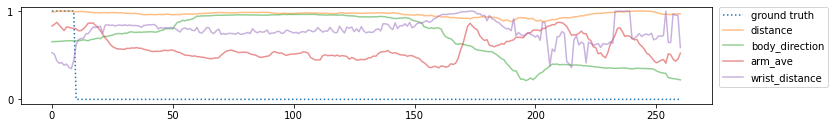

07_001_28_429_425


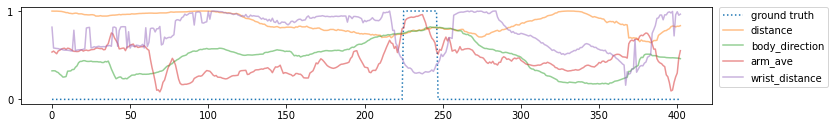

07_001_29_453_436


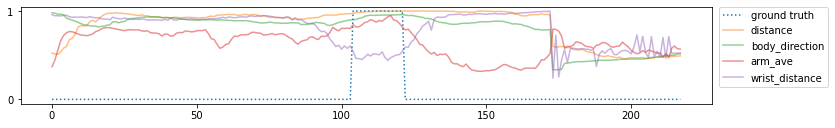

07_001_30_453_459


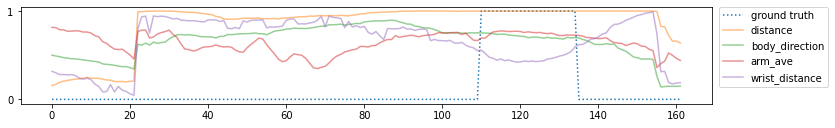

07_001_31_476_461


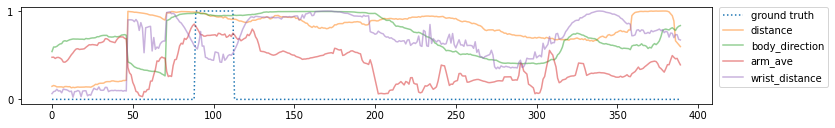

07_001_32_489_491


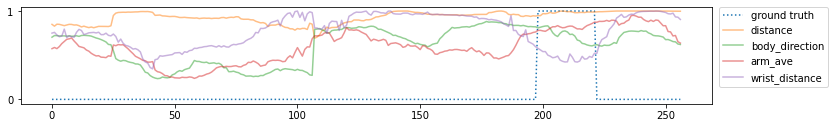

07_001_33_506_489


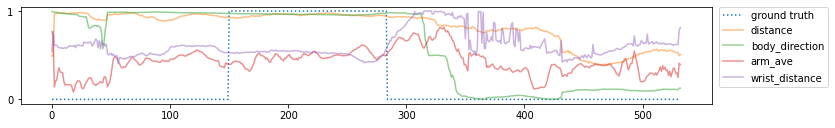

07_001_34_506_505


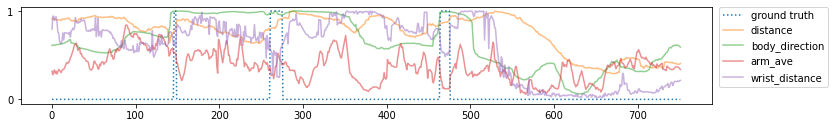

07_001_35_506_505


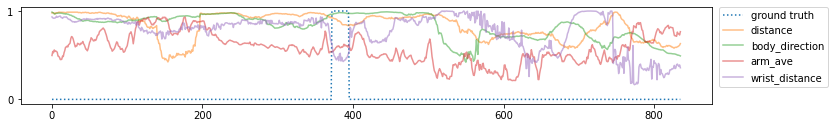

07_001_36_505_543


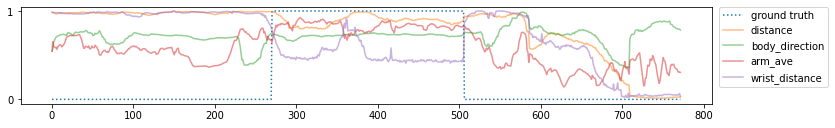

07_001_36_543_505


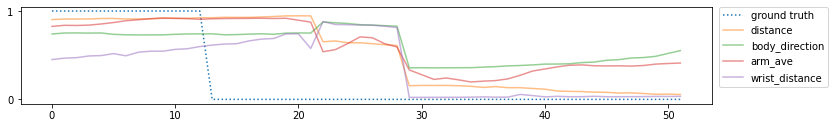

07_001_37_543_565


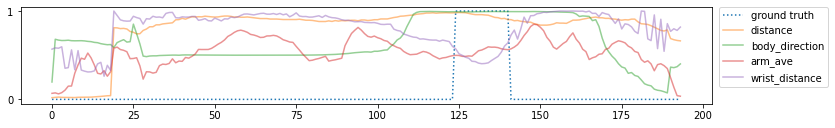

07_001_38_588_543


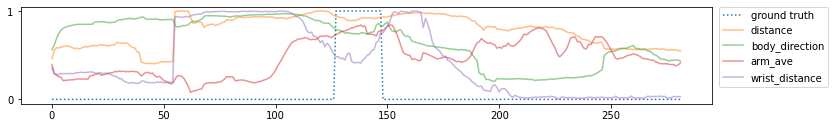

07_001_39_588_543


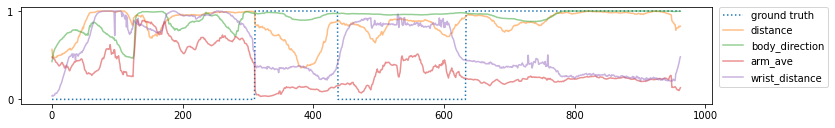

07_001_39_543_588


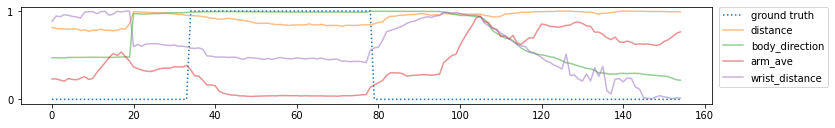

07_001_40_588_543


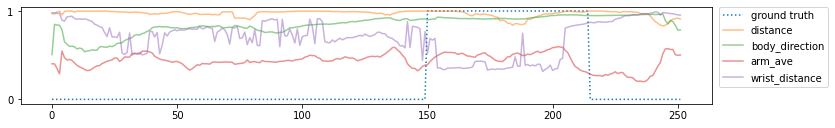

07_001_41_588_617


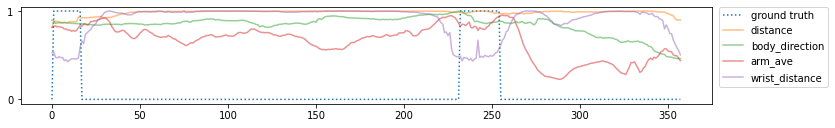

07_001_42_617_623


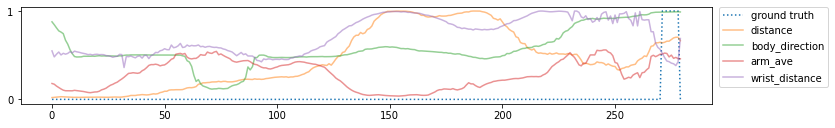

07_001_43_632_633


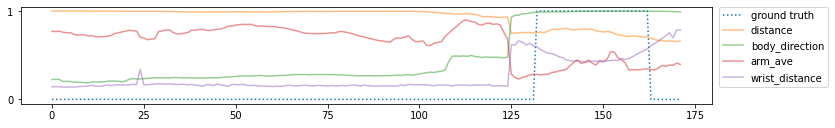

07_001_44_632_633


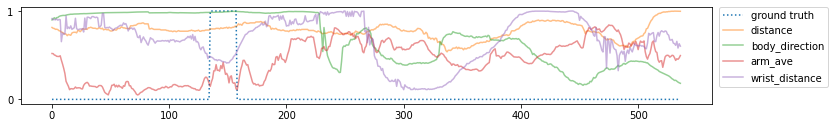

07_001_45_633_652


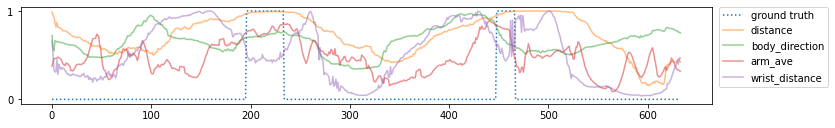

07_001_46_652_651


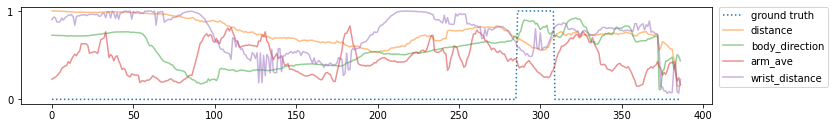

07_001_47_663_669


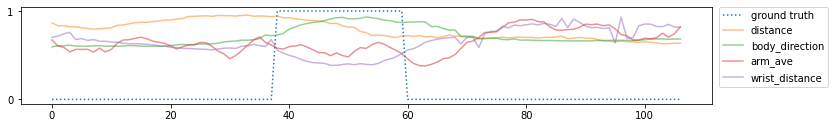

07_001_48_672_663


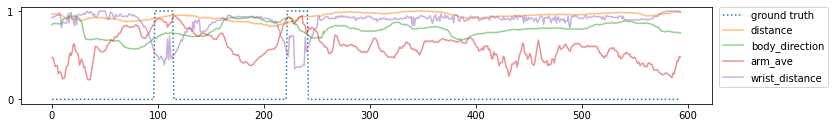

07_001_49_663_672


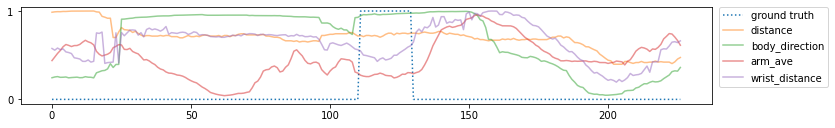

07_001_50_684_672


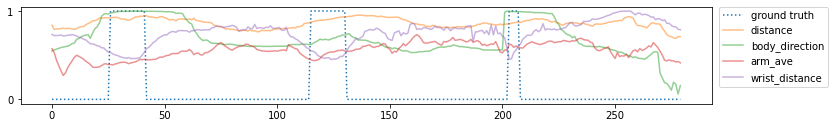

08_001_01_3_6


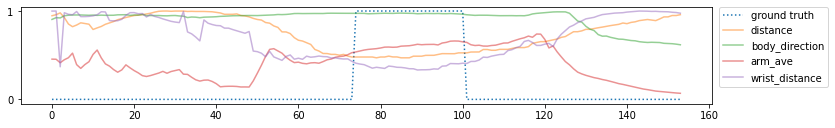

08_001_03_26_32


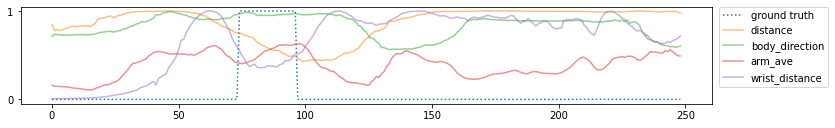

08_001_04_39_41


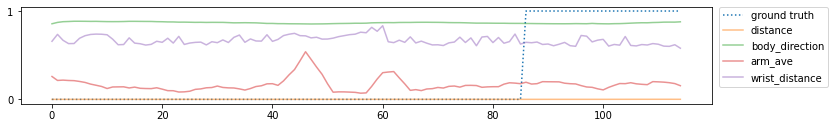

08_001_07_68_70


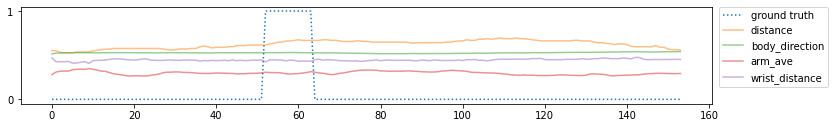

08_001_08_74_75


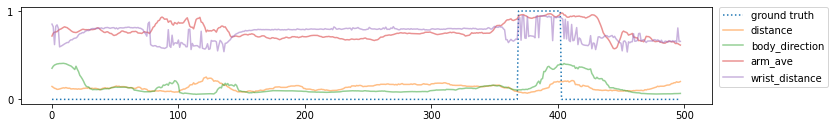

08_001_09_91_89


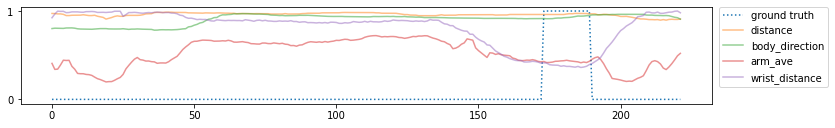

08_001_37_388_389


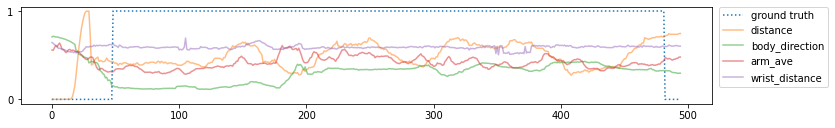

08_002_01_10_7


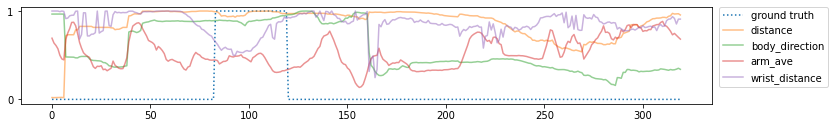

08_002_02_10_30


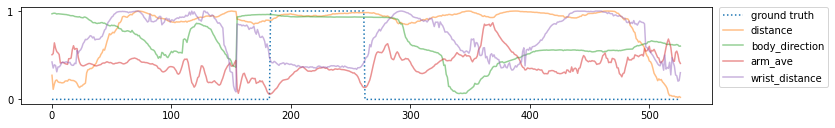

08_002_03_37_41


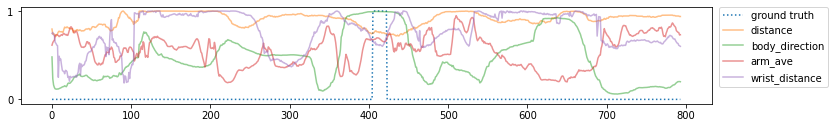

08_002_04_52_50


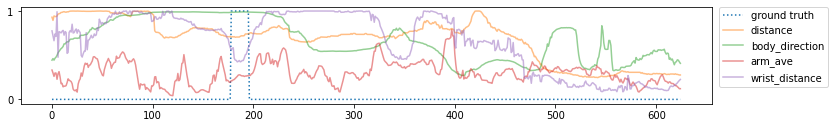

08_002_05_52_61


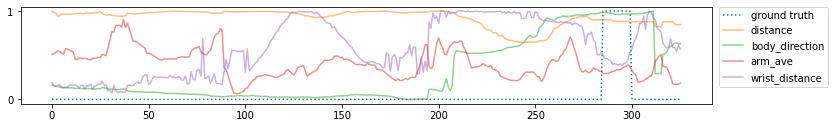

08_002_06_71_72


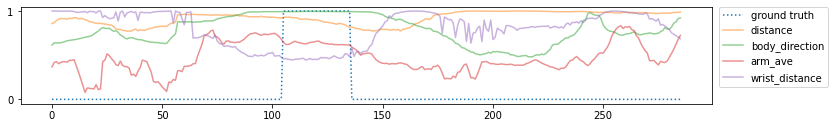

08_002_06_72_71


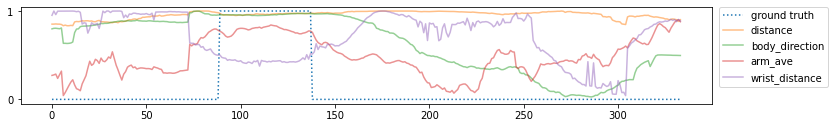

08_002_07_72_85


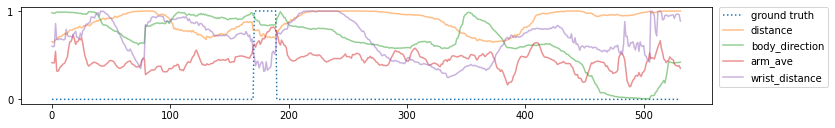

08_002_08_72_98


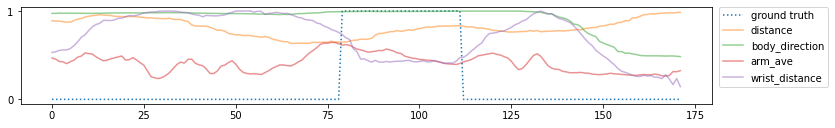

08_002_09_72_102


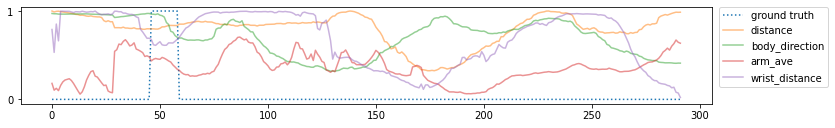

08_002_09_72_106


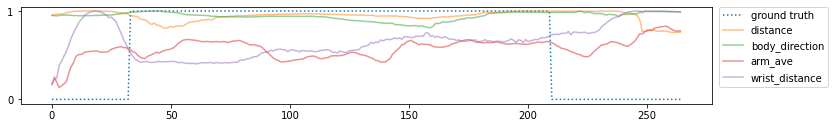

08_002_10_72_110


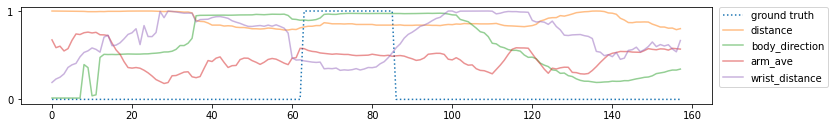

08_002_11_118_125


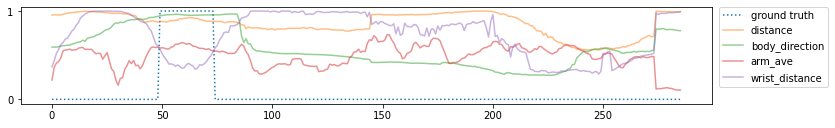

08_002_12_125_129


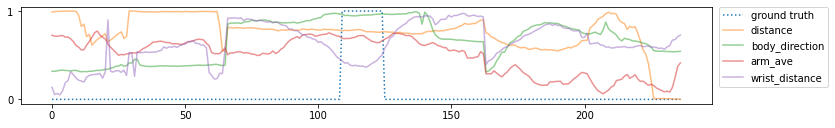

08_002_13_147_126


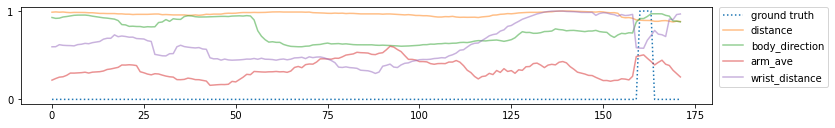

08_002_14_154_159


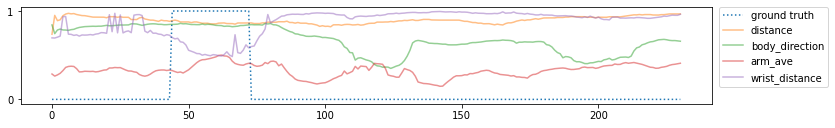

08_002_15_154_153


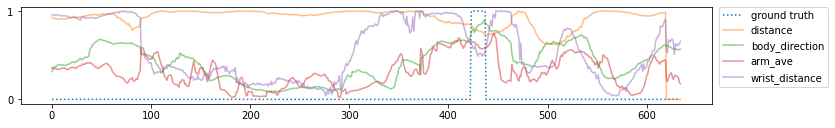

08_002_16_165_182


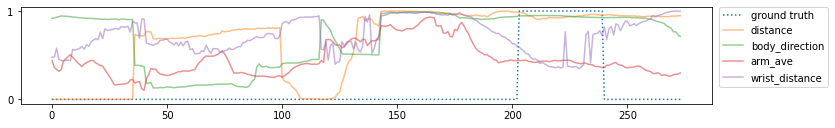

08_002_17_206_182


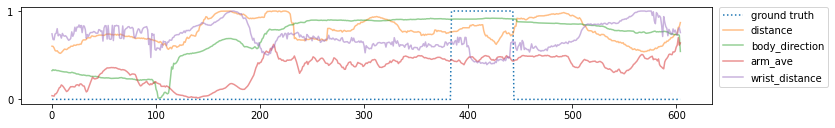

08_002_18_217_221


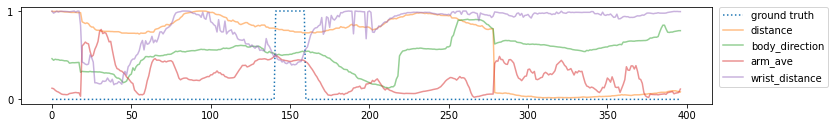

08_002_20_229_241


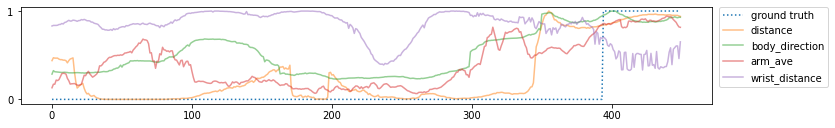

08_002_20_229_249


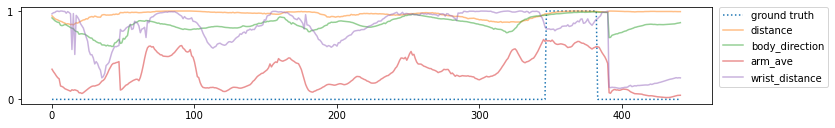

08_002_21_243_245


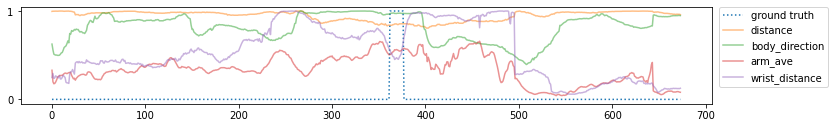

08_002_22_269_266


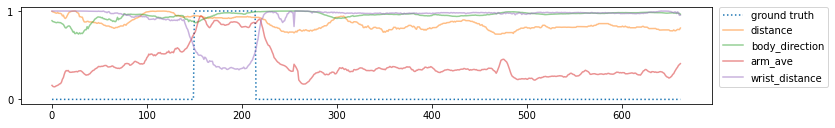

08_002_23_266_279


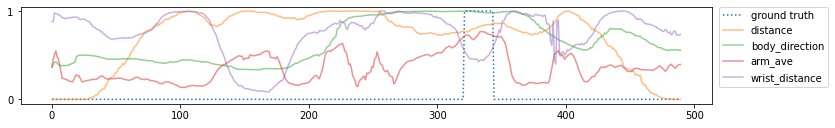

08_002_24_285_289


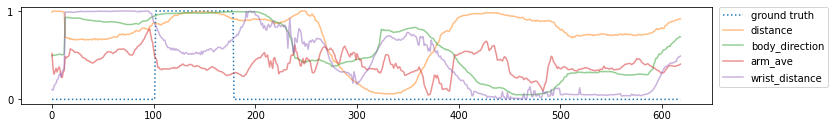

08_002_25_302_297


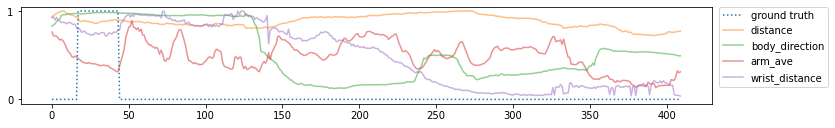

08_002_26_302_308


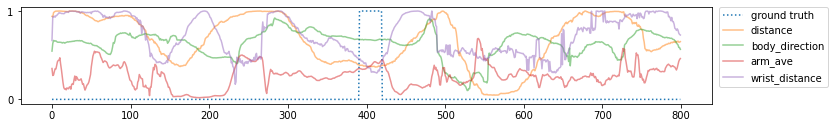

08_002_27_302_328


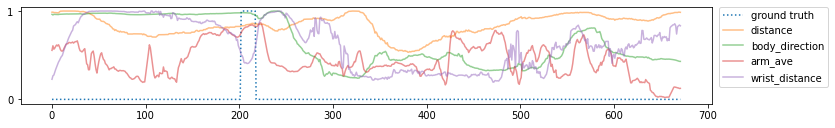

08_002_28_302_333


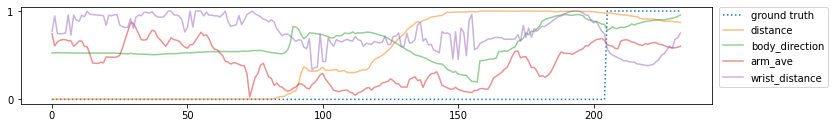

08_002_29_344_333


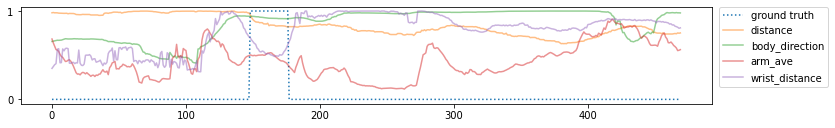

08_002_30_351_353


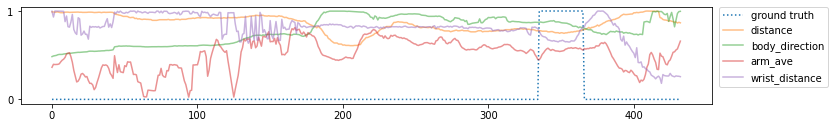

08_002_31_362_344


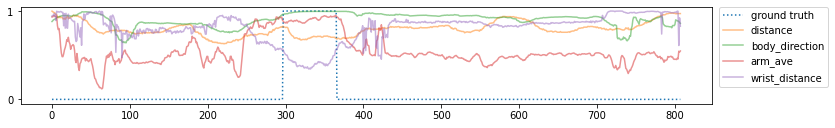

08_002_32_362_344


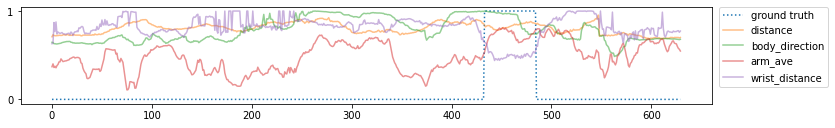

08_002_33_362_344


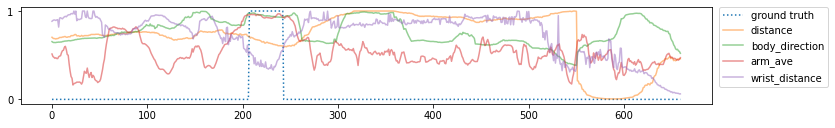

08_002_34_396_390


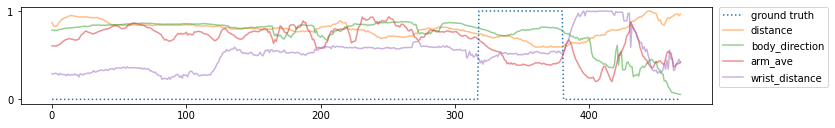

08_002_35_403_404


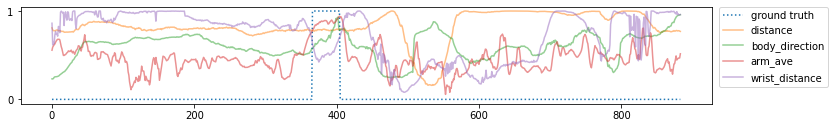

08_002_36_403_404


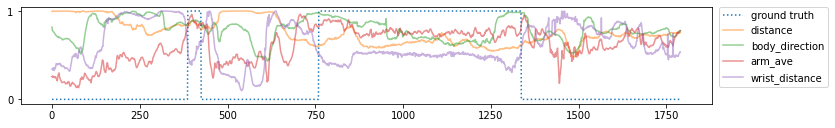

08_002_37_403_404


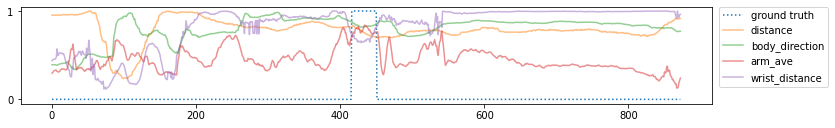

08_002_38_403_404


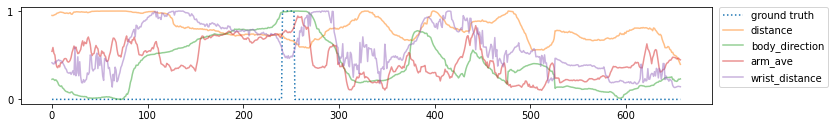

08_002_39_403_439


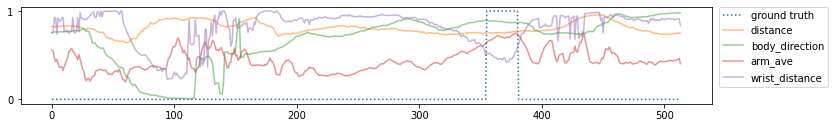

08_002_40_439_446


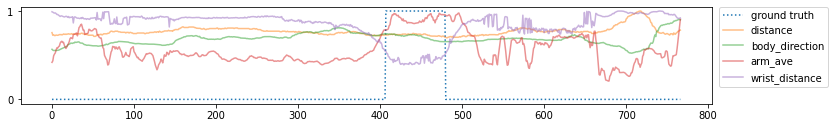

08_002_41_439_446


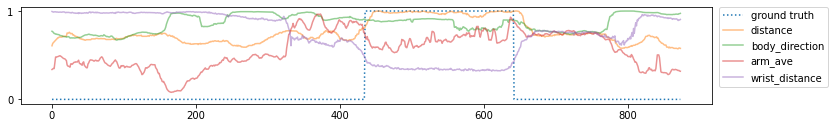

08_002_42_439_446


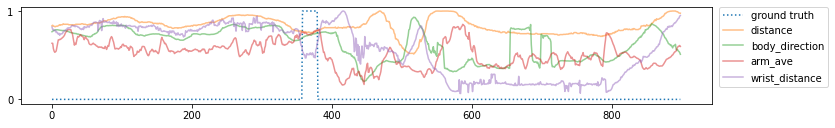

08_002_43_439_446


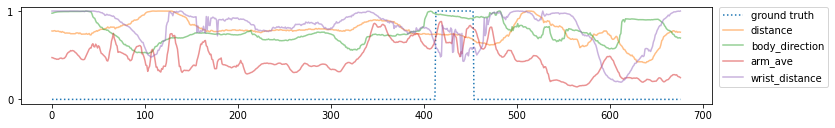

08_002_44_446_473


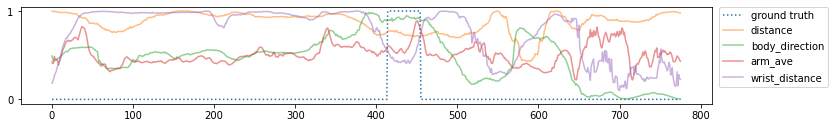

08_002_45_446_479


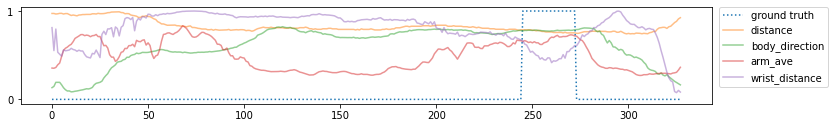

08_002_45_446_480


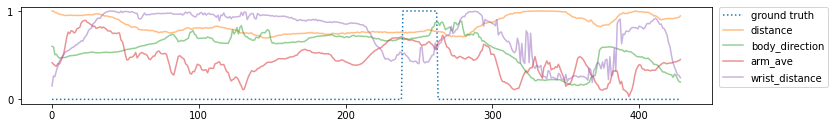

08_002_46_446_480


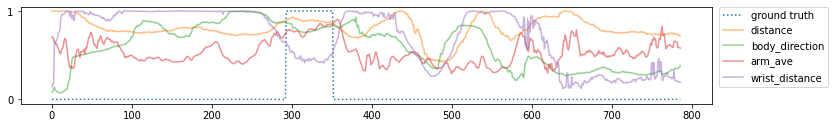

09_001_01_1_8


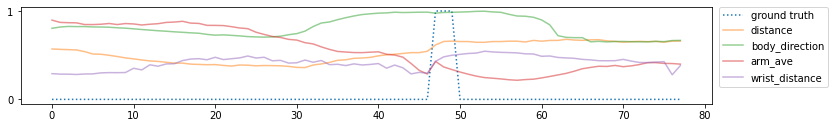

09_001_01_8_1


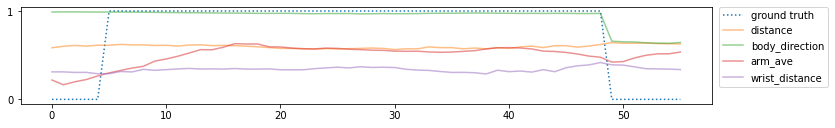

09_001_02_18_29


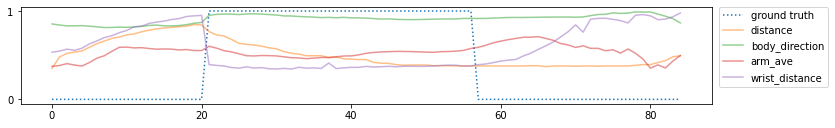

09_001_02_29_18


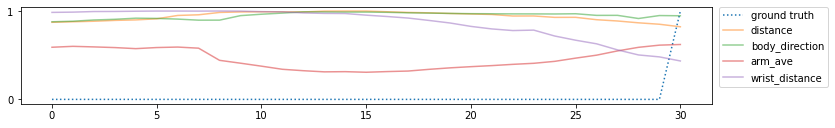

09_001_03_40_45


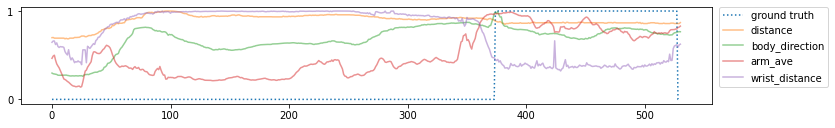

09_001_04_60_59


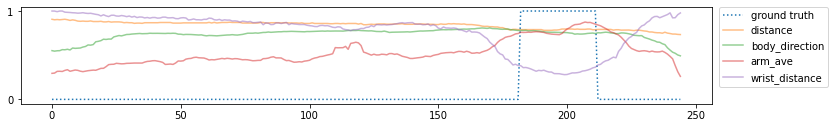

09_001_05_78_75


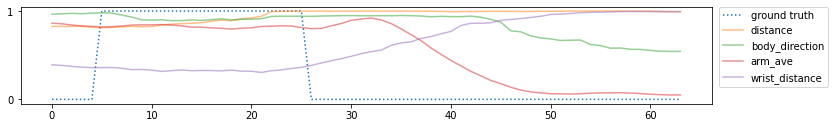

09_001_06_82_85


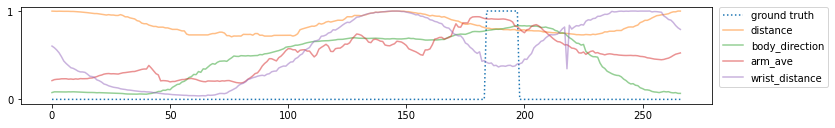

09_001_07_92_96


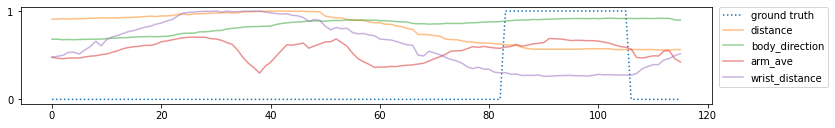

09_001_08_102_105


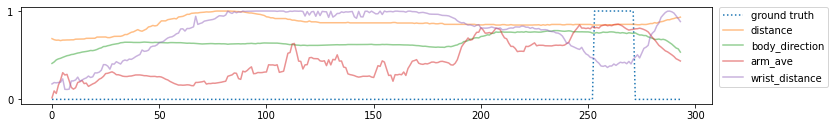

09_001_09_114_116


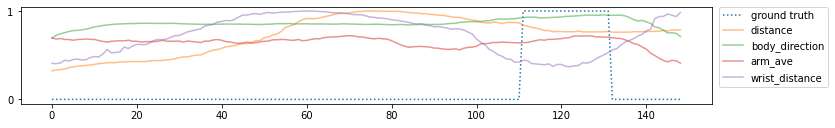

09_002_01_4_6


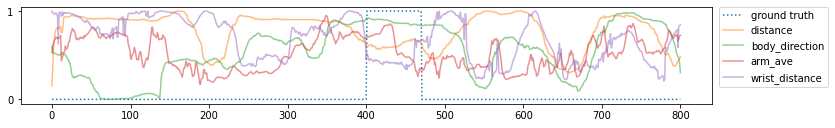

09_002_02_8_18


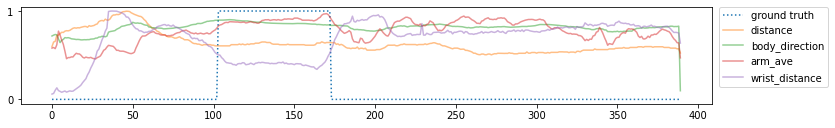

09_002_02_18_8


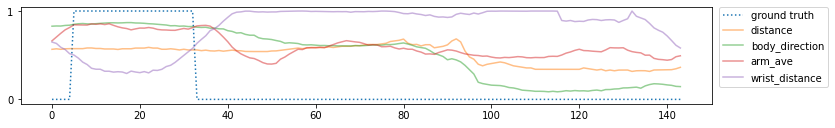

09_002_03_26_27


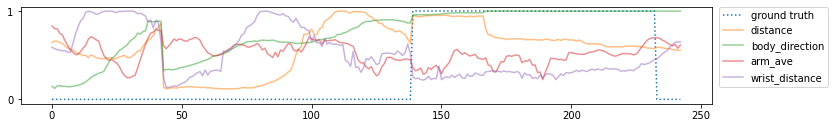

09_002_03_27_26


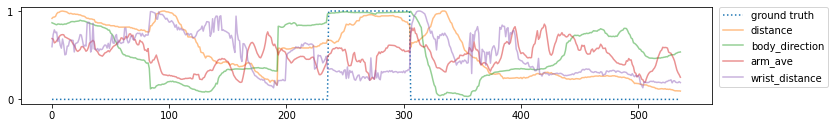

09_002_04_28_26


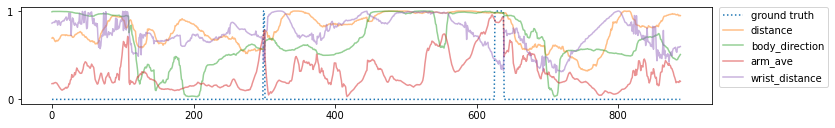

09_002_04_26_28


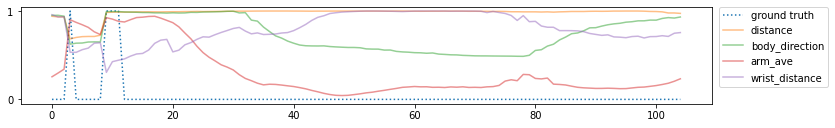

09_002_06_63_50


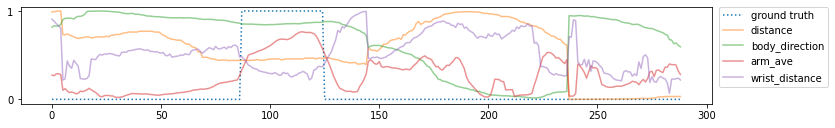

09_002_07_75_60


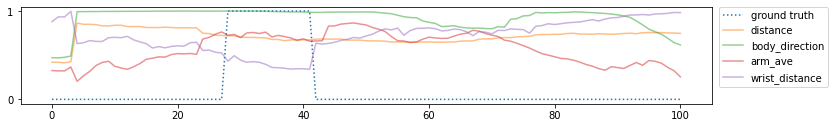

09_002_09_94_92


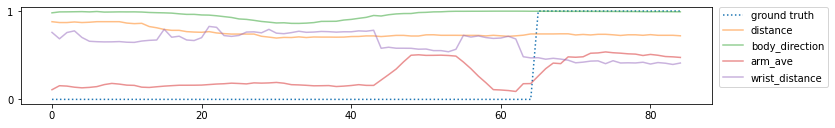

09_002_10_99_101


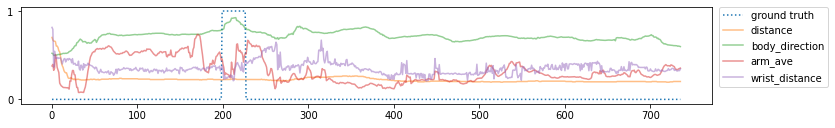

09_002_11_92_99


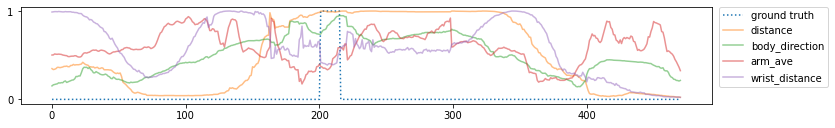

09_002_12_92_99


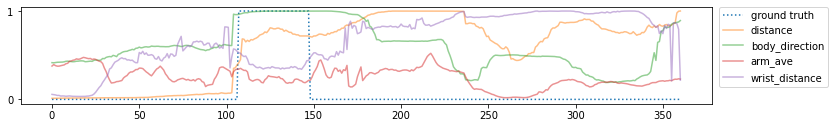

09_002_13_137_92


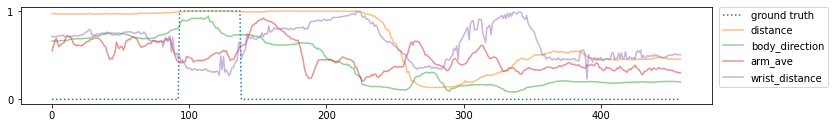

09_002_14_155_158


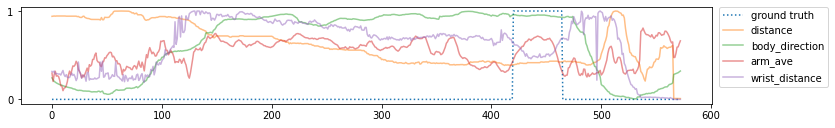

09_002_15_176_178


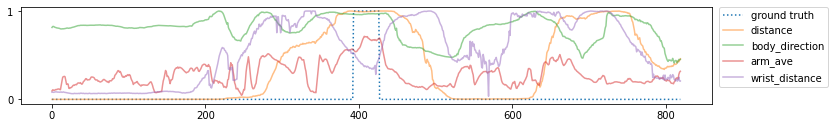

09_002_16_176_189


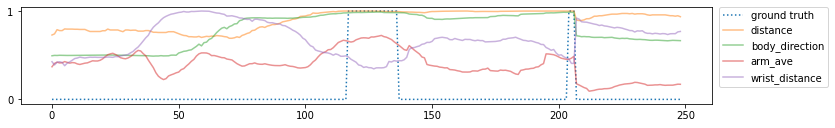

09_002_17_196_193


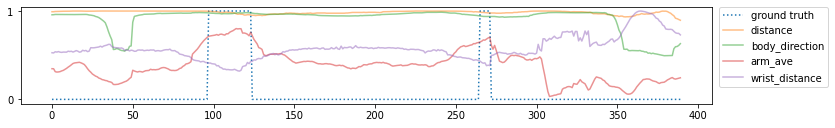

09_002_18_196_193


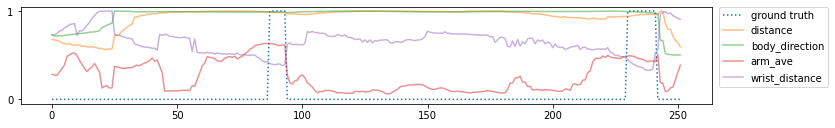

09_002_18_193_196


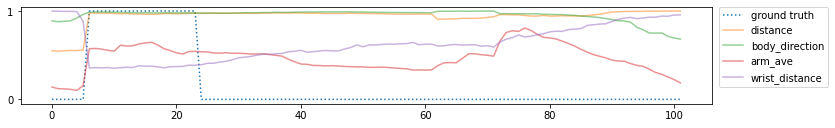

In [34]:
columns = ["distance", "body_direction", "arm_ave", "wrist_distance"]
for key in x_dict.keys():
    x_lst = np.array(x_dict[key])
    y_lst = y_dict[key]

    if 1 not in y_lst:
        continue

    if len(x_lst) < 30:
        continue

    print(key)
    plt.figure(figsize=(10, 1.5))
    # plt.rcParams["font.size"] = 20
    # plt.rcParams["font.family"] = 'Times New Roman'
    plt.plot(y_lst, linestyle=':', label='ground truth')
    for i, x in enumerate(x_lst.T):
        plt.plot(x, alpha=0.5, label=columns[i])
    plt.ylim((-0.05, 1.05))
    plt.yticks([0, 1])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

    plt.show()